In [103]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

from utils import *

## Encode Cifar-5

In [3]:
data_cifar = np.loadtxt("data/cifar-5/data.txt")
labels_cifar = np.loadtxt("data/cifar-5/labels.txt")
classes = np.unique(labels_cifar)
data_cifar.shape, labels_cifar.shape, classes.shape

((2500, 4224), (2500,), (5,))

In [47]:
cluster_per_class = 2
kmeans = KMeans(n_clusters=int(len(classes)*cluster_per_class), n_jobs=-1, verbose=1).fit(data_cifar)
# kmeans = KMeans(n_clusters=6, n_jobs=-1, verbose=1).fit(data_cifar)

In [48]:
kmeans.cluster_centers_.shape, kmeans.labels_.shape, np.unique(kmeans.labels_).shape

((10, 4224), (2500,), (10,))

(array([496., 500., 154., 314., 371., 128.,   5., 186., 165., 181.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

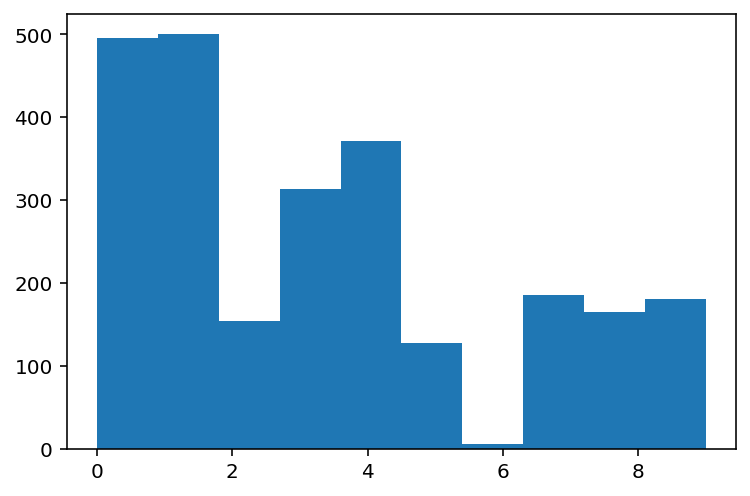

In [49]:
plt.hist(kmeans.labels_, bins=np.unique(kmeans.labels_).shape[0])

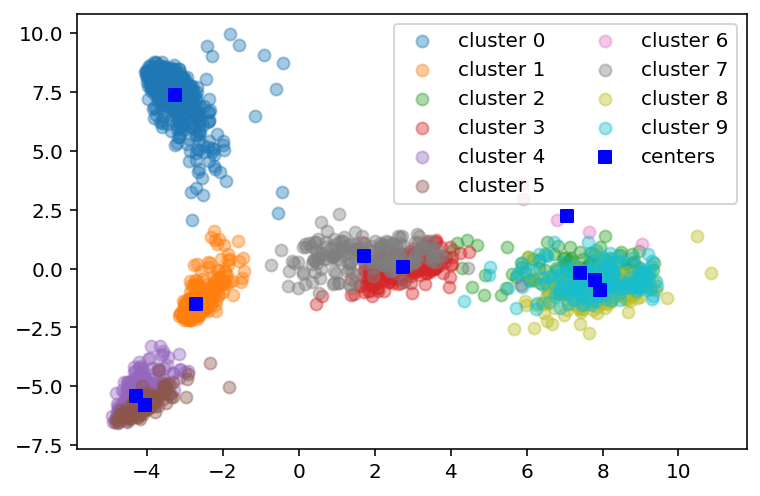

In [50]:
%config InlineBackend.figure_format = 'retina'
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_cifar)
centers = pca.transform(kmeans.cluster_centers_)

for label in np.unique(kmeans.labels_):
    mask = (kmeans.labels_ == label)
    plt.scatter(data_pca[mask, 0], data_pca[mask, 1], alpha=0.4, label="cluster " + str(int(label)))
plt.scatter(centers[:, 0], centers[:, 1], marker='s', label='centers', c='b')
plt.legend(ncol=2)

In [56]:
threshold = 10
cluster_cnts = np.histogram(kmeans.labels_, bins=len(np.unique(kmeans.labels_)))[0]

cluster_remain = np.where(cluster_cnts > 10)
center_remain = kmeans.cluster_centers_[cluster_cnts > 10]

In [66]:
elim_labels = np.where(cluster_cnts <= 10)
data_cifar[kmeans.labels_ == elim_labels[0], :].shape
(data_cifar[kmeans.labels_ == elim_labels[0], :] - center_remain).shape
# labels_remain = kmeans.labels_.copy()
# labels_remain[]

ValueError: operands could not be broadcast together with shapes (5,4224) (9,4224) 

In [69]:
kmeans.cluster_centers_ = kmeans.cluster_centers_[cluster_remain]

In [72]:
kmeans.labels_[kmeans.labels_ == elim_labels[0]] = kmeans.predict(data_cifar[kmeans.labels_ == elim_labels[0], :])

In [77]:
kmeans.labels_.shape, labels_cifar.shape

((2500,), (2500,))

## Subclass Exploring 5-Class

In [246]:
data_cifar = np.loadtxt('data/cifar-5/encoding.txt')
subclasses_cifar, idx, freq = np.unique(data_cifar[:, :], axis=0, return_counts=True, return_index=True)
subclasses_cifar.shape, freq, idx

((8, 2),
 array([  1,   4, 500, 500, 496, 499, 300, 200], dtype=int64),
 array([ 892, 1247, 2000,    0, 1000,  500, 1500, 1502], dtype=int64))

The 892-th sample and 1247-th sample should be mistakenly classified in VGGNet for Cifar-100.

In [104]:
data = np.loadtxt('data/encoding_merged.txt')
data.shape

(2500, 3)

In [235]:
subclasses, freq = np.unique(list(data[:, :-1]), axis=0, return_counts=True)
subclasses.shape, freq.shape

((45, 2), (45,))

In [207]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f

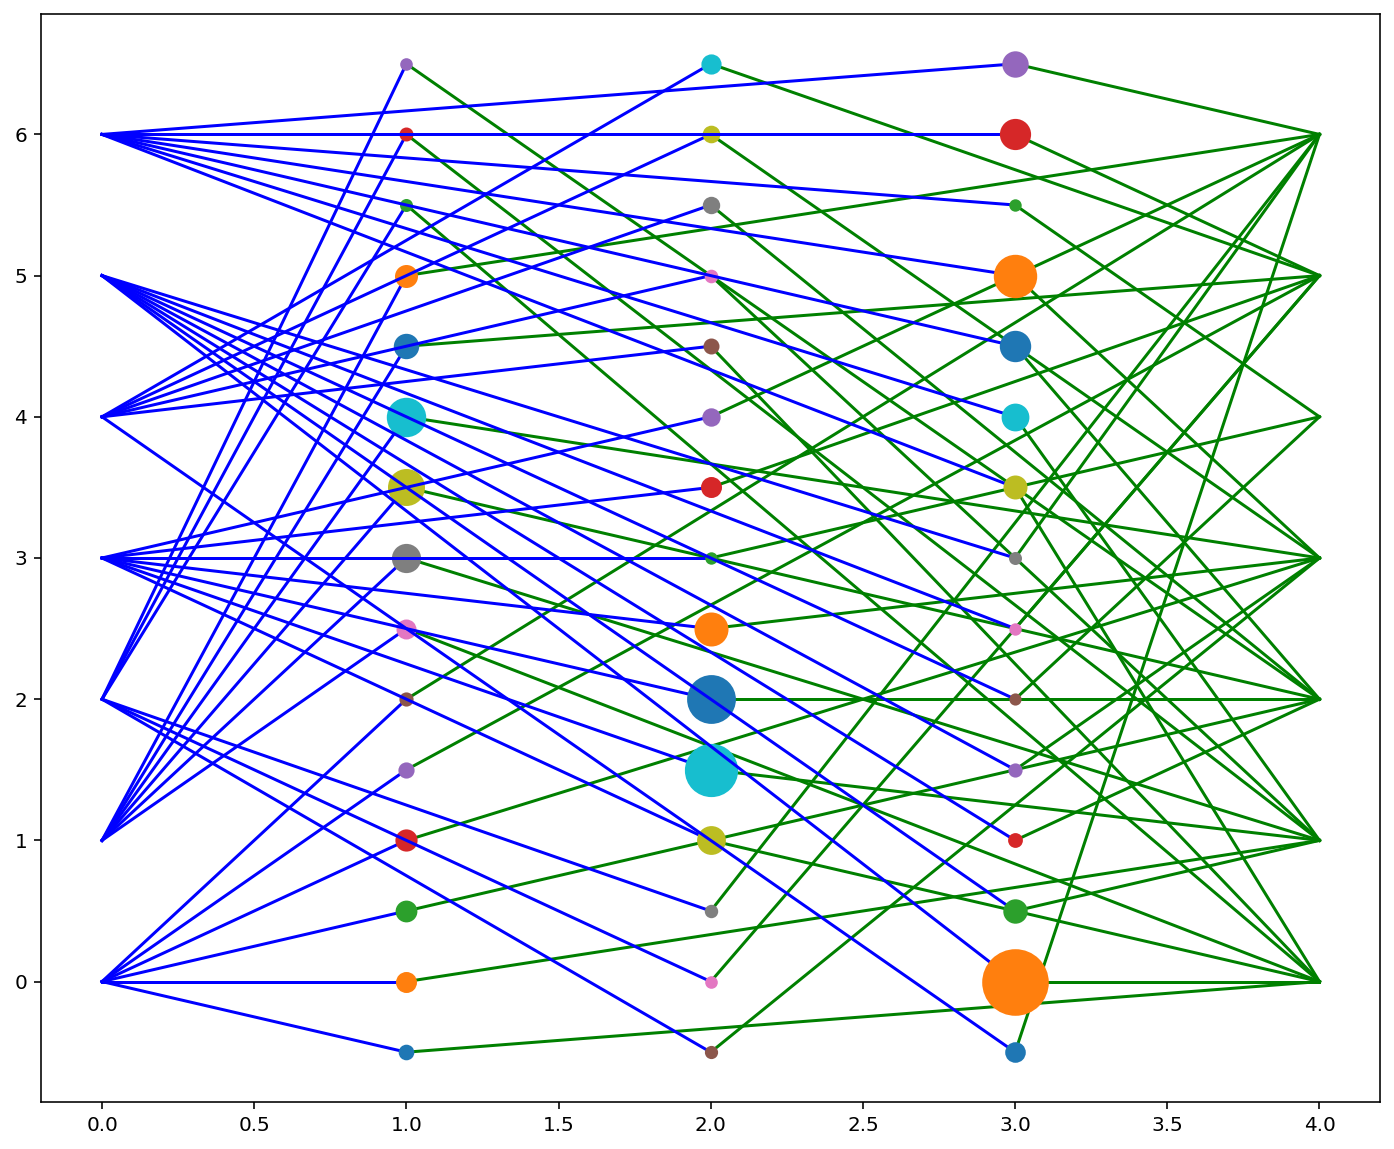

In [231]:
def plot_network_venn(data, subclasses, cluster_sets):
    count = lambda x: sum((data[:, 0] == x[0]) & (data[:, 1] == x[1]))
    
    G = nx.Graph()
    cl_pos = dict()
    cmap = ['b', 'g']
    for i, subclass in enumerate(subclasses):
        for j, cl in enumerate(subclass):
            plt.plot([1+1*(i // 15), j*4], [0.5*(i % 15)-0.5, cl*1], c=cmap[j])
        G.add_node(i, encoding=subclass, size=count(subclass)*5+200, shape='skyblue', pos=(1+1*(i // 15), 0.5*(i % 15)-0.5))
        plt.plot(1+1*(i // 15), 0.5*(i % 15)-0.5, marker='o', ms=count(subclass)/10+5, label=)
    for i, clusters in enumerate(cluster_sets):
        for cl in clusters:
            G.add_node('{:.0f}-{:.0f}'.format(i, cl), encoding=None, size=500, shape='orangered', pos=(i*4, cl*1))
            
            
    sizes = [s for n, s in G.nodes(data='size')]
    shapes = [s for n, s in G.nodes(data='shape')]
    
#     nx.draw_networkx(G, node_size=0, pos=G.nodes(data='pos'), node_color=shapes)

plt.figure(figsize=[12, 10])
plot_network_venn(data, subclasses, [np.unique(subclasses[:, i]) for i in range(subclasses.shape[1])])

In [122]:
help(nx.draw_networkx)

Help on function draw_networkx in module networkx.drawing.nx_pylab:

draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds)
    Draw the graph G using Matplotlib.
    
    Draw the graph with Matplotlib with options for node positions,
    labeling, titles, and many other drawing features.
    See draw() for simple drawing without labels or axes.
    
    Parameters
    ----------
    G : graph
       A networkx graph
    
    pos : dictionary, optional
       A dictionary with nodes as keys and positions as values.
       If not specified a spring layout positioning will be computed.
       See :py:mod:`networkx.drawing.layout` for functions that
       compute node positions.
    
    arrows : bool, optional (default=True)
       For directed graphs, if True draw arrowheads.
       Note: Arrows will be the same color as edges.
    
    arrowstyle : str, optional (default='-|>')
        For directed graphs, choose the style of the arrowsheads.
        See :py:class: `matplo